In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pathlib
import zipfile
import torch
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torch.nn as nn
import pandas as pd
import seaborn as sns

In [2]:
import os

In [3]:
! conda install -y gdown
!gdown --id 1fOCHmxc1MrXc-AHnvcqYvHu0y9LupOhV
!gdown --id 1vkTHZqjYynj0-eymcFkPND4GvJvyd8BE
!unzip -u ./test.zip -d ./test 
!unzip -u ./train.zip -d ./train 

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.10.3               |   py37h89c1867_2         3.1 MB  conda-forge
    filelock-3.1.0             |     pyhd8ed1ab_1          11 KB  conda-forge
    gdown-3.14.0               |     pyhd8ed1ab_0          12 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.1.0-pyhd8ed1ab_1
  gdown              conda-forge/noarch::gdown-3.14.0-pyhd8ed1ab_0

The following packages will be UPDATED:

  conda                               4.10.3-py37h89c1867_1 --> 4.10.3-py37h89c1867_2



gdown-3.14.0         | 12 KB     | ####################

In [4]:
train='./train'
test='./test'

classes = os.listdir(test) 
print(classes)

def totalSize(path):
    sum = 0;
    for path, subdirs, files in os.walk(path):  ## walk directory    
        sum += len(files)
    return sum

print("Train Number Of Images : ",totalSize(train))
print("Test Number Of Images : ",totalSize(test))

['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'no_tumor']
Train Number Of Images :  2870
Test Number Of Images :  394


In [6]:

BATCH_SIZE = 16  
IMAGE_SIZE = 224 
transform = transforms.Compose([

                                # torchvision.transforms.ColorJitter(brightness=0.4),
#                                 transforms.RandomRotation(20,expand=True), 
                                transforms.Resize(IMAGE_SIZE),  ## image resize
                                transforms.ToTensor(),
                                transforms.CenterCrop(IMAGE_SIZE),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                
                               ])
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train,transform=transform),
    batch_size=BATCH_SIZE, shuffle=True
)

transform2 = transforms.Compose([
                                
                                transforms.Resize(IMAGE_SIZE),  ## image resize
                                transforms.ToTensor(), ## array converted into torch tensor and then divided by 255 (1.0/255)
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                               ])

test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test,transform=transform2),
    batch_size=BATCH_SIZE, shuffle=True
)

In [7]:
import torchvision.models as models

models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [8]:
# from torch.optim.lr_scheduler import StepLR
import torchvision.models as models
alexnet= models.alexnet(pretrained=True)

# image size must be >= 299 x 299 during training if aux_logits is set to be True.

alexnet.cuda()
num_classes =4
batch_size = BATCH_SIZE

learning_rate=0.0001

optimizer = torch.optim.Adam(alexnet.parameters(),lr=learning_rate)

# scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
 
criterion = torch.nn.CrossEntropyLoss()

alexnet.fc = nn.Linear(4096, 4)
alexnet.cuda()
print("Model Is Ready To Run ")

Model Is Ready To Run 


In [9]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
PATH='./alexnet.pth'

training_losses = []
training_accuracy = []
validation_losses = []
validation_accuracy = []
totalsteps = []
epochs = 10
steps = 0
running_loss = 0
print_every = 1

#epoch iteration
for epoch in range(epochs):
    accuracy = 0
    for inputs, labels in train_loader:
        alexnet.train()
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad() # clears old gradients from the last step (otherwise you’d just accumulate the gradients from all loss.backward() calls).
        
        logps = alexnet.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward() # computes the derivative of the loss w.r.t. the parameters (or anything requiring gradients) using backpropagation
        optimizer.step() # the optimizer to take a step based on the gradients of the parameters.
 
        #Calculate traning accuracy
        pred = torch.argmax(logps, dim=1)
        correct = pred.eq(labels)
       
        running_loss += loss.item()
        accuracy += torch.mean(correct.float())
        
        if steps % print_every == 0:
            after_train_accuracy=accuracy/print_every
            validation_loss = 0
            accuracy = 0
            alexnet.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = alexnet.forward(inputs)
                    batch_loss = criterion(logps, labels)                    
                    validation_loss += batch_loss.item()
                    pred = torch.argmax(logps, dim=1)
                    correct = pred.eq(labels)
                    accuracy += torch.mean(correct.float())
            
            training_losses.append(running_loss/print_every)
            training_accuracy.append(after_train_accuracy)
            validation_losses.append(validation_loss/len(test_loader))
            validation_accuracy.append(accuracy/len(test_loader))
            totalsteps.append(steps)
            print(f"Device {device} "
                  f"Epoch {epoch+1}/{epochs} "
                  f"Step {steps} "
                  f"Train loss: {running_loss/print_every:f} "
                  f"Train accuracy: {after_train_accuracy:f} "
                  f"Validation loss: {validation_loss/len(test_loader):f} "
                  f"Validation accuracy: {accuracy/len(test_loader):f}")
            running_loss = 0
            accuracy = 0
            alexnet.train()
print('Finish Train')
torch.save(alexnet.state_dict(), PATH)

Device cuda Epoch 1/10 Step 1 Train loss: 12.045819 Train accuracy: 0.000000 Validation loss: 8.232077 Validation accuracy: 0.005000
Device cuda Epoch 1/10 Step 2 Train loss: 8.325586 Train accuracy: 0.000000 Validation loss: 6.224655 Validation accuracy: 0.051500
Device cuda Epoch 1/10 Step 3 Train loss: 5.553313 Train accuracy: 0.062500 Validation loss: 4.725085 Validation accuracy: 0.182500
Device cuda Epoch 1/10 Step 4 Train loss: 4.551647 Train accuracy: 0.437500 Validation loss: 3.797720 Validation accuracy: 0.275500
Device cuda Epoch 1/10 Step 5 Train loss: 2.637908 Train accuracy: 0.562500 Validation loss: 3.635042 Validation accuracy: 0.263000
Device cuda Epoch 1/10 Step 6 Train loss: 3.727978 Train accuracy: 0.125000 Validation loss: 2.875653 Validation accuracy: 0.266500
Device cuda Epoch 1/10 Step 7 Train loss: 3.158252 Train accuracy: 0.375000 Validation loss: 2.429457 Validation accuracy: 0.259500
Device cuda Epoch 1/10 Step 8 Train loss: 2.448414 Train accuracy: 0.500000

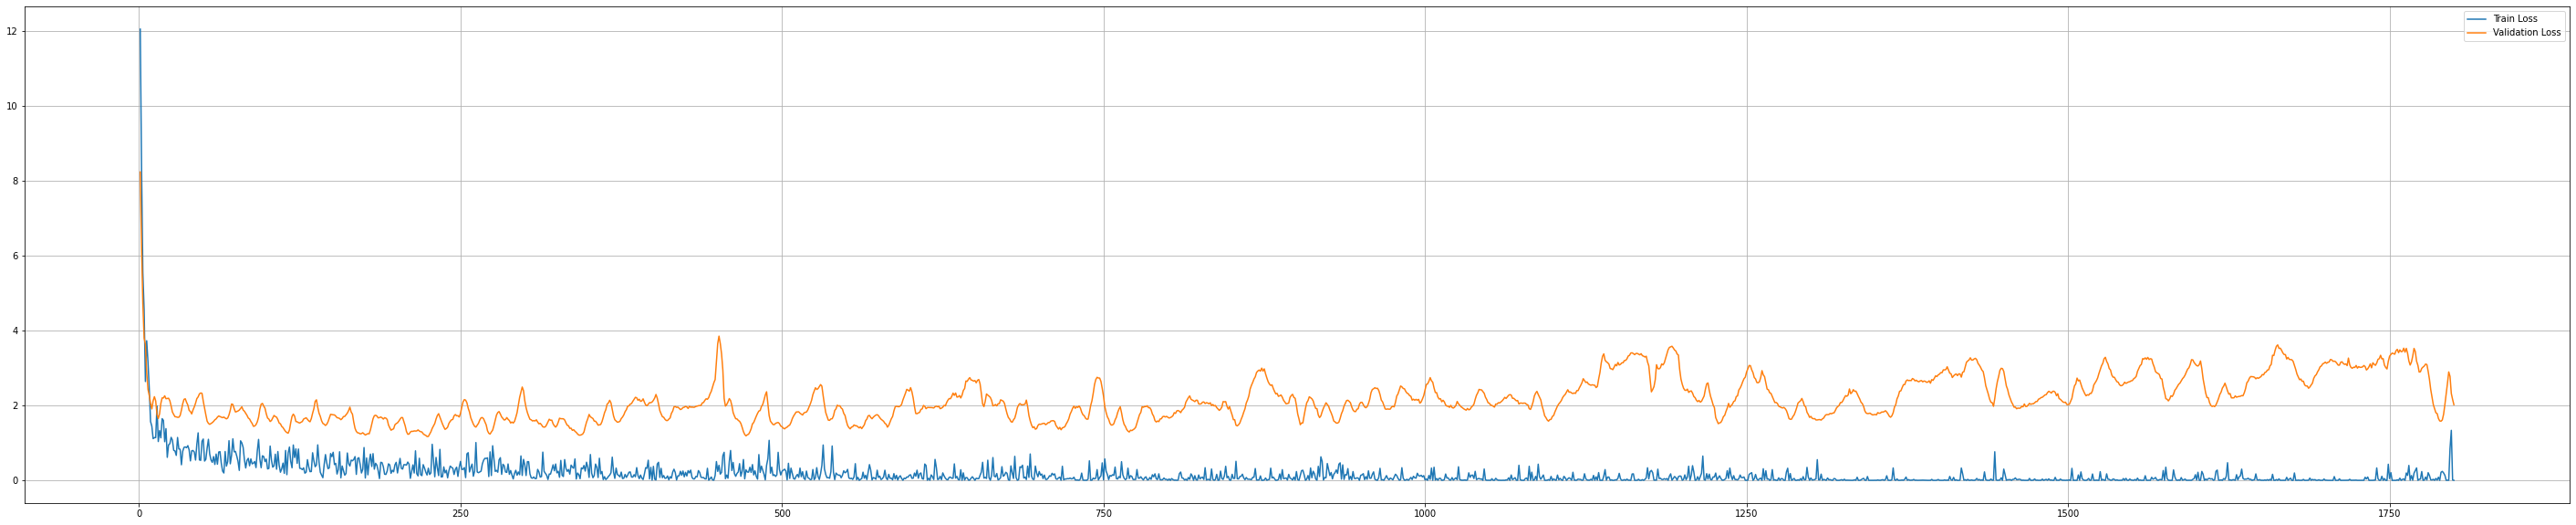

In [12]:
#display stats in graph
plt.figure(figsize=(50, 10))
plt.plot(totalsteps, training_losses, label='Train Loss')
plt.plot(totalsteps, validation_losses, label='Validation Loss')
plt.legend()
plt.grid()
plt.show()

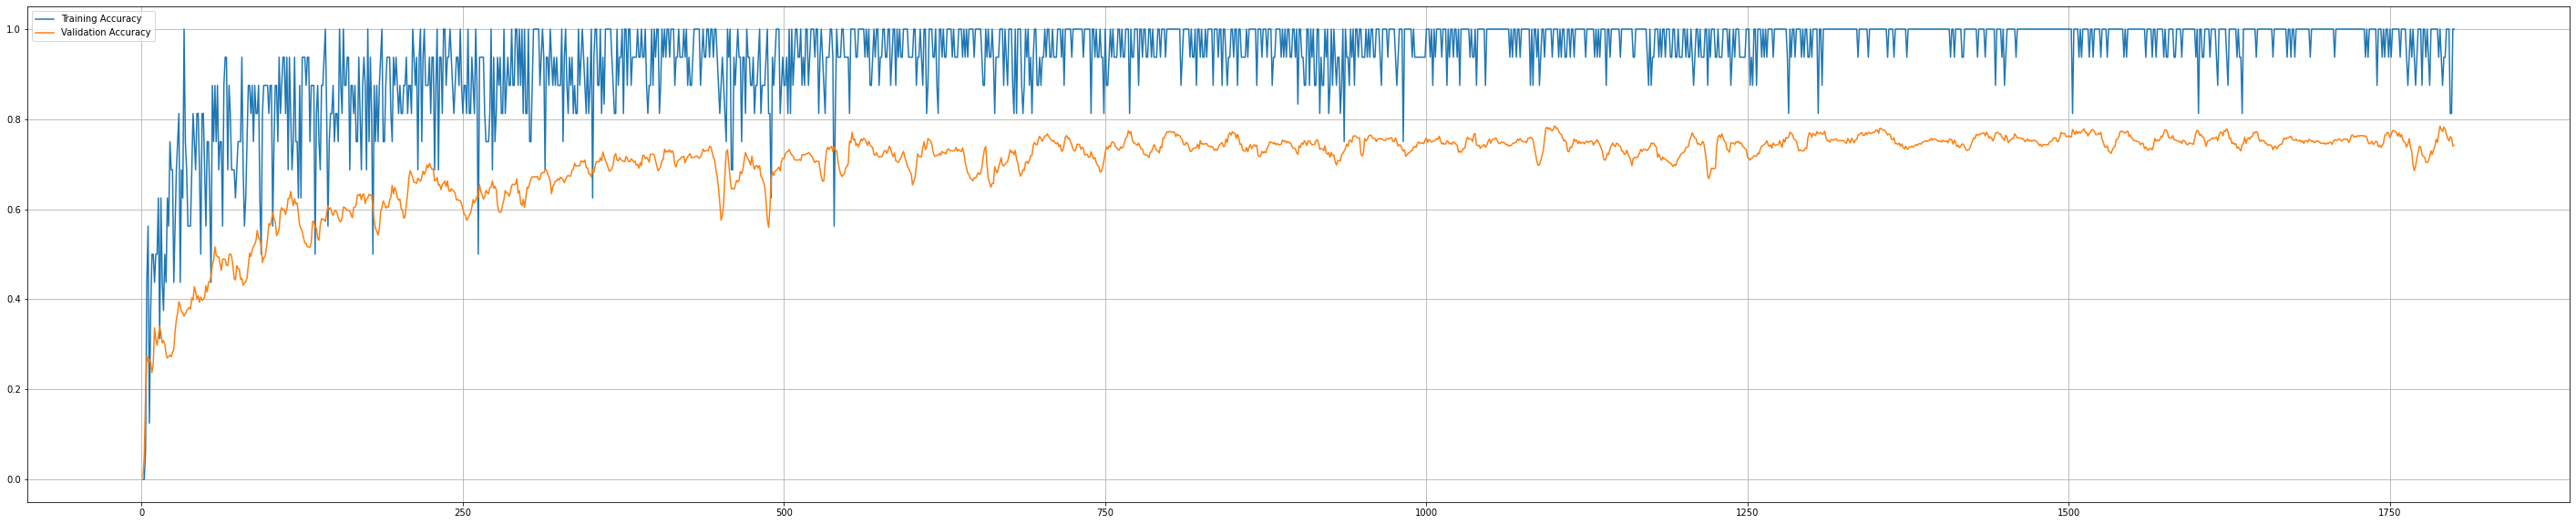

In [13]:
#display stats in graph
plt.figure(figsize=(50, 10))
plt.plot(totalsteps, training_accuracy, label='Training Accuracy')
plt.plot(totalsteps, validation_accuracy, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [14]:
total = 0
correct=0
with torch.no_grad():
    alexnet.eval()
    for inputs, labels in test_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = alexnet(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(total)
print(correct) 

print('Accuracy of the network test images: %d %%' % (100 * correct / total))

394
292
Accuracy of the network test images: 74 %


In [15]:
y_true_tensor = torch.tensor([]).cuda()
y_pred_tensor = torch.tensor([]).cuda()
alexnet.eval()
for i,(inputs, labels) in enumerate(test_loader):

  inputs, labels = inputs.to(device), labels.to(device)
  outputs = alexnet(inputs)
  _, preds = torch.max(outputs, 1)
  y_true_tensor = torch.cat((y_true_tensor,labels))
  y_pred_tensor = torch.cat((y_pred_tensor,preds))

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [17]:
y_true = y_true_tensor.tolist()
y_pred = y_pred_tensor.tolist()

In [18]:
matrix = confusion_matrix(y_true,y_pred)
matrix

array([[ 22,  58,  20,   0],
       [  0, 112,   3,   0],
       [  0,   2, 103,   0],
       [  0,   3,  16,  55]])

In [19]:
test_set = torchvision.datasets.ImageFolder(test, transform=transform2)


In [20]:
target_names = list(test_set.class_to_idx.keys())

In [21]:
classify_report = classification_report(y_true, y_pred, target_names=target_names)
print(classify_report)

                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.22      0.36       100
meningioma_tumor       0.64      0.97      0.77       115
        no_tumor       0.73      0.98      0.83       105
 pituitary_tumor       1.00      0.74      0.85        74

        accuracy                           0.74       394
       macro avg       0.84      0.73      0.70       394
    weighted avg       0.82      0.74      0.70       394



Text(0.5, 14.09375, 'Predicted label')

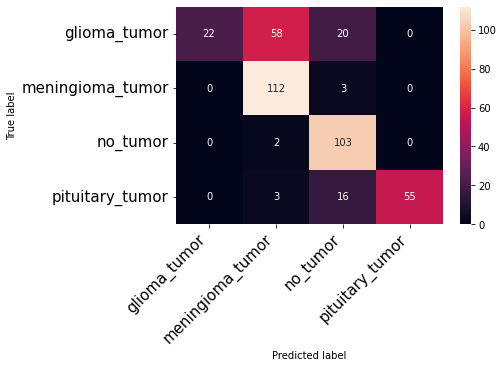

In [22]:
import pandas as pd
import seaborn as sns
df_cm = pd.DataFrame(matrix, index=target_names, columns=target_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [23]:
# def test_class_probabilities(googlenet, device, test_loader, which_class):
#     googlenet.eval()
#     actuals = []
#     probabilities = []
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = googlenet(data)
#             prediction = output.argmax(dim=1, keepdim=True)
#             actuals.extend(target.view_as(prediction) == which_class)
#             probabilities.extend(np.exp(output[:, which_class]))
#     return [i.item() for i in actuals], [i.item() for i in probabilities]

# which_class = 4
# actuals, class_probabilities = test_class_probabilities(model, device, test_loader, which_class)

# fpr, tpr, _ = roc_curve(actuals, class_probabilities)
# roc_auc = auc(fpr, tpr)
# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC for digit=%d class' % which_class)
# plt.legend(loc="lower right")
# plt.show()
